In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = pathlib.Path("E:\GolfData\Frames")

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

5719


In [4]:
# loader parameters

batch_size = 32
img_height = 360
img_width = 640

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5719 files belonging to 2 classes.
Using 4576 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5719 files belonging to 2 classes.
Using 1143 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Negatives', 'Positives']


In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 360, 640, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
num_classes = 2

model = Sequential([

    # preprocessing and feature augmentation
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])


In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 360, 640, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 360, 640, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 360, 640, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 360, 640, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 360, 640, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 320, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 320, 32)      4

In [14]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
143/143 [==============================] - 84s 457ms/step - loss: 0.2681 - accuracy: 0.9178 - val_loss: 0.0707 - val_accuracy: 0.9808
Epoch 2/10
143/143 [==============================] - 73s 510ms/step - loss: 0.0520 - accuracy: 0.9867 - val_loss: 0.0368 - val_accuracy: 0.9913
Epoch 3/10
143/143 [==============================] - 71s 495ms/step - loss: 0.0362 - accuracy: 0.9915 - val_loss: 0.0307 - val_accuracy: 0.9939
Epoch 4/10
143/143 [==============================] - 71s 496ms/step - loss: 0.0307 - accuracy: 0.9926 - val_loss: 0.0278 - val_accuracy: 0.9948
Epoch 5/10
143/143 [==============================] - 85s 594ms/step - loss: 0.0273 - accuracy: 0.9932 - val_loss: 0.0442 - val_accuracy: 0.9860
Epoch 6/10
143/143 [==============================] - 67s 470ms/step - loss: 0.0153 - accuracy: 0.9967 - val_loss: 0.0483 - val_accuracy: 0.9869
Epoch 7/10
143/143 [==============================] - 62s 435ms/step - loss: 0.0246 - accuracy: 0.9937 - val_loss: 0.0192 - val_ac

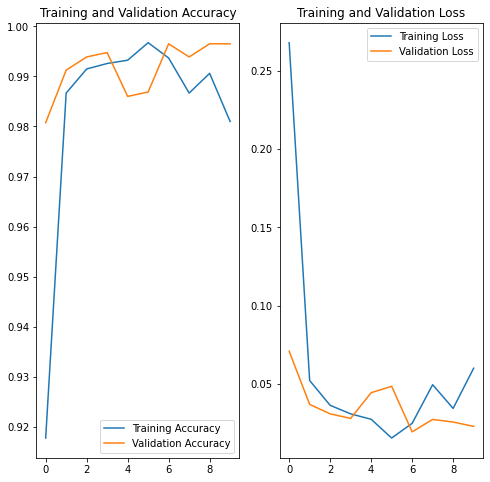

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# prediction

# positieve predictie
image_path = "E:\GolfData\Frames\Positives\ZDOgtiAmT40_3104.png"
img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

# negatieve predictie
image_path = "E:\GolfData\Frames\\Negatives\\AAAAFishing-Hobby-And-A-Passion.png"
img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))


This image most likely belongs to Positives with a 99.82 percent confidence.
This image most likely belongs to Negatives with a 100.00 percent confidence.


In [21]:
# save model
model.save("./supervisedNeuralNet/models/model")


INFO:tensorflow:Assets written to: ./supervisedNeuralNet/models/model\assets
